**Coursework for 《Advances in Machine Learning》, 2025 Spring.**
***
This notebook demonstrates the implementation of [Trading financial indices with reinforcement learning agents](https://doi.org/10.1016/j.eswa.2018.02.032).

Our github repository is [here](https://github.com/FlyingParachute/MathFin_RL).

**Group members:** Jingtong Xu, Jinyi Lin, Sunqinli Wang, Xingjian Zhao.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1 Load and Prepare Data

## 1.1 Load Data

**Portfolios 1**: the combination of SPX and AGG;

**Portfolio 2**: the combination of SPX and T-NOTE 10YR.

In [15]:
file_path_1 = '../data/processed/Portfolio_1.xlsx'
sheets = ['Quarterly', 'Semi Annually', 'Yearly']
ptf1 = {sheet: pd.read_excel(file_path_1, sheet_name=sheet) for sheet in sheets}

ptf1_quarterly = ptf1['Quarterly'].set_index('Dates')
ptf1_semi_annual = ptf1['Semi Annually'].set_index('Dates')
ptf1_annual = ptf1['Yearly'].set_index('Dates')

In [17]:
file_path_2 = '../data/processed/Portfolio_2.xlsx'
sheets = ['Quarterly', 'Semi Annually', 'Yearly']
ptf2 = {sheet: pd.read_excel(file_path_2, sheet_name=sheet) for sheet in sheets}


ptf2_quarterly = ptf2['Quarterly'].set_index('Dates')
ptf2_semi_annual = ptf2['Semi Annually'].set_index('Dates')
ptf2_annual = ptf2['Yearly'].set_index('Dates')

In [21]:
#Sample data
ptf1_annual.head()

,SPXret_a,AGGret_a
Dates,,
1977-12-30,-0.115020,0.030363
1978-12-29,0.010620,0.013937
1979-12-31,0.123088,0.019293
1980-12-31,0.257736,0.027051
1981-12-31,-0.097304,0.062485


## 1.2 Define the State Space

## 1.3 Split Data for Training and Testing

# 2 Action Space

| Action | 1      | 2      | 3      | 4      | 5      |
|--------|--------|--------|--------|--------|--------|
| **S&P 500 (%)** | 0      | 25     | 50     | 75     | 100    |
| **AGG or T-bill bond (%)** | 100    | 75     | 50     | 25     | 0      |

# 3 Train the Agent

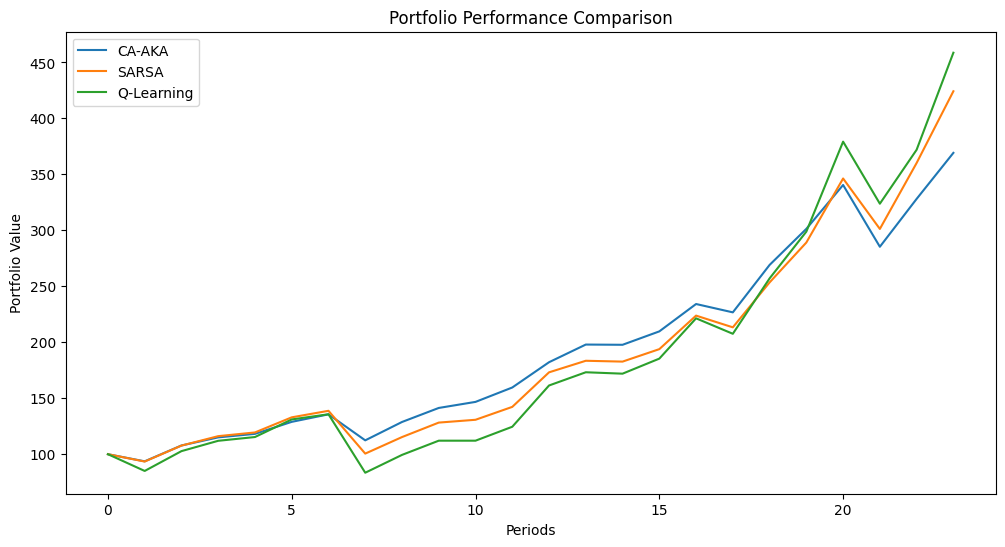

In [25]:
# 定义全局参数
gamma = 0.9     # 折扣因子
lambda_ = 0.9   # 资格迹衰减率
alpha = 0.1     # 学习率
epsilon = 0.01  # 探索概率
eta = 0.1       # 差分夏普比率平滑参数

# 状态编码函数
def get_state(spx_ret, agg_ret):
    state = ''
    state += '1' if spx_ret >= 0 else '0'
    state += '1' if agg_ret >= 0 else '0'
    return state

# 离散动作空间 (股票比例)
actions = [0.0, 0.25, 0.5, 0.75, 1.0]

# 初始化Q矩阵 (4状态 x 5动作)
def initialize_q():
    states = ['11', '01', '10', '00']
    return pd.DataFrame(np.random.rand(4, 5), index=states, columns=actions)

# SARSA(λ)算法实现
class SarsaLambdaAgent:
    def __init__(self, reward_type='return'):
        self.q = initialize_q()
        self.e = pd.DataFrame(np.zeros((4, 5)), index=self.q.index, columns=self.q.columns)
        self.reward_type = reward_type
        self.A = 0  # 差分夏普比率参数
        self.B = 0
        
    def get_reward(self, spx_ret, agg_ret, action):
        portfolio_ret = action * spx_ret + (1 - action) * agg_ret
        
        if self.reward_type == 'return':
            return portfolio_ret
        else:  # 差分夏普比率
            delta_A = portfolio_ret - self.A
            delta_B = portfolio_ret**2 - self.B
            self.A += eta * delta_A
            self.B += eta * delta_B
            
            if (self.B - self.A**2)**1.5 == 0:
                return 0
            return (self.B * delta_A - 0.5 * self.A * delta_B) / (self.B - self.A**2)**1.5
    
    def update(self, state, action, reward, next_state, next_action):
        delta = reward + gamma * self.q.loc[next_state, next_action] - self.q.loc[state, action]
        self.e.loc[state, action] += 1
        
        # 更新所有状态动作对的Q值和资格迹
        for s in self.q.index:
            for a in self.q.columns:
                self.q.loc[s, a] += alpha * delta * self.e.loc[s, a]
                self.e.loc[s, a] *= gamma * lambda_
                
    def choose_action(self, state):
        if np.random.rand() < epsilon:
            return np.random.choice(actions)
        else:
            return self.q.loc[state].idxmax()

# Q(λ)算法实现
class QLambdaAgent(SarsaLambdaAgent):
    def update(self, state, action, reward, next_state):
        delta = reward + gamma * self.q.loc[next_state].max() - self.q.loc[state, action]
        self.e.loc[state, action] += 1
        
        for s in self.q.index:
            for a in self.q.columns:
                self.q.loc[s, a] += alpha * delta * self.e.loc[s, a]
                self.e.loc[s, a] *= gamma * lambda_

# TD(λ)连续动作代理
class TDContinuousAgent:
    def __init__(self):
        self.theta = {'11': [0.5, 0], '01': [0.5, 0], 
                     '10': [0.5, 0], '00': [0.5, 0]}
        self.e_trace = {'11': [0, 0], '01': [0, 0],
                       '10': [0, 0], '00': [0, 0]}
        
    def get_allocation(self, state):
        if np.random.rand() < epsilon:
            return np.random.uniform(0, 1)
        else:
            return max(0, min(1, self.theta[state][0]))
    
    def update(self, state, spx_ret, agg_ret, reward, next_state):
        # 计算梯度
        gradient = [spx_ret - agg_ret, 1]
        
        # 计算TD误差
        current_value = self.theta[state][0] * (spx_ret - agg_ret) + self.theta[state][1]
        next_value = self.theta[next_state][0] * (spx_ret - agg_ret) + self.theta[next_state][1]
        delta = reward + gamma * next_value - current_value
        
        # 更新资格迹
        for i in range(2):
            self.e_trace[state][i] = gamma * lambda_ * self.e_trace[state][i] + gradient[i]
            
        # 更新参数
        for i in range(2):
            self.theta[state][i] += alpha * delta * self.e_trace[state][i]

# 回测框架
def backtest(data, train_years, agent_type, freq='annual'):
    train_data = data.iloc[:train_years]
    test_data = data.iloc[train_years:]
    
    # 训练阶段
    if agent_type == 'continuous':
        agent = TDContinuousAgent()
    elif agent_type == 'sarsa':
        agent = SarsaLambdaAgent()
    elif agent_type == 'qlearning':
        agent = QLambdaAgent()
    
    # 自适应训练逻辑
    for i in range(1, len(train_data)):
        prev_row = train_data.iloc[i-1]
        current_row = train_data.iloc[i]
        
        state = get_state(prev_row['SPXret_a'], prev_row['AGGret_a'])
        
        if agent_type == 'continuous':
            action = agent.get_allocation(state)
        else:
            action = agent.choose_action(state)
        
        # 计算奖励
        portfolio_ret = action * current_row['SPXret_a'] + (1 - action) * current_row['AGGret_a']
        
        if isinstance(agent, SarsaLambdaAgent) and agent.reward_type == 'sharpe':
            reward = agent.get_reward(current_row['SPXret_a'], current_row['AGGret_a'], action)
        else:
            reward = portfolio_ret
        
        # 更新状态
        next_state = get_state(current_row['SPXret_a'], current_row['AGGret_a'])
        
        # 更新代理
        if agent_type == 'sarsa':
            next_action = agent.choose_action(next_state)
            agent.update(state, action, reward, next_state, next_action)
        elif agent_type == 'qlearning':
            agent.update(state, action, reward, next_state)
        elif agent_type == 'continuous':
            agent.update(state, current_row['SPXret_a'], current_row['AGGret_a'], 
                        reward, next_state)
    
    # 测试阶段
    portfolio_values = [100]  # 初始投资100美元
    current_value = 100
    
    for i in range(len(test_data)):
        if i == 0:
            prev_row = train_data.iloc[-1]
        else:
            prev_row = test_data.iloc[i-1]
            
        current_row = test_data.iloc[i]
        
        state = get_state(prev_row['SPXret_a'], prev_row['AGGret_a'])
        
        if agent_type == 'continuous':
            action = agent.get_allocation(state)
        else:
            action = agent.choose_action(state)
        
        # 计算收益
        ret = action * current_row['SPXret_a'] + (1 - action) * current_row['AGGret_a']
        current_value *= (1 + ret)
        portfolio_values.append(current_value)
        
        # 自适应更新（仅对AKA）
        if 'adaptive' in agent_type:
            # 这里需要实现动态更新逻辑
            pass
            
    return portfolio_values


# 示例使用
if __name__ == "__main__":
    # 加载数据（假设数据格式正确）
    data = ptf1_annual
    
    # 运行CA-AKA代理
    ca_aka_returns = backtest(data, train_years=25, agent_type='continuous')
    
    # 运行其他代理的比较
    sarsa_returns = backtest(data, train_years=25, agent_type='sarsa')
    qlearn_returns = backtest(data, train_years=25, agent_type='qlearning')
    
    # 绘制结果（需要matplotlib）
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12,6))
    plt.plot(ca_aka_returns, label='CA-AKA')
    plt.plot(sarsa_returns, label='SARSA')
    plt.plot(qlearn_returns, label='Q-Learning')
    plt.legend()
    plt.title('Portfolio Performance Comparison')
    plt.ylabel('Portfolio Value')
    plt.xlabel('Periods')
    plt.show()
